In [34]:
from typing import Sequence, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from IPython.display import display

import logging

In [35]:
logging.basicConfig(format='[%(asctime)s] [%(levelname)s]: %(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
_logger = logging.getLogger("data_hack.preliminary")

In [36]:
# Load Data regarding winds and aerodynamic forces.
F_table = pd.read_csv("data/F.csv")
Wind_table = pd.read_csv("data/Wind.csv")
print("Forces")
display(F_table)
print("Winds")
display(Wind_table)
F_table.columns

Forces


,V,Fa
0,0,0.000
1,10,14.019
2,20,80.836
3,30,240.060
4,40,449.910
5,50,686.020
6,60,983.300
7,70,1361.600
8,80,1804.900
9,90,2289.100


Winds


,Y,Wx,Wz
0,0,3.38,-1.81
1,100,3.52,-2.88
2,200,3.84,-2.60
3,300,4.39,-1.18
4,400,4.75,-1.42
5,500,4.53,-1.94
6,600,3.58,-1.73
7,700,3.37,-2.25
8,800,4.37,-2.16
9,900,2.99,-2.42


Index(['V', 'Fa'], dtype='object')

In [37]:
# Try to predict winds
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
train, test = train_test_split(Wind_table, test_size=0.8)
gp = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=10)
gb = GradientBoostingRegressor(n_estimators=100, max_depth=2)

gp.fit(train["Y"].values.reshape(-1,1), train["Wx"])
print(gp.score(test["Y"].values.reshape(-1,1), test["Wx"]))
wx_predict = gp.predict(Wind_table["Y"].values.reshape(-1,1))
gp.fit(train["Y"].values.reshape(-1,1), train["Wz"])
print(gp.score(test["Y"].values.reshape(-1,1), test["Wz"]))
wz_predict = gp.predict(Wind_table["Y"].values.reshape(-1,1))

-1.6686560615899957
-1.148246299614029


e:\source\repos\best.hack\preliminary\.venv\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos


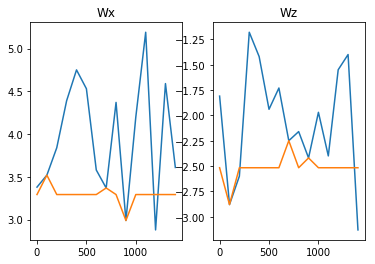

In [38]:
fig, (wx, wz) = plt.subplots(1, 2, sharex=True)
wx.set_title("Wx")
wx.plot(Wind_table["Y"], Wind_table["Wx"])
wx.plot(Wind_table["Y"], wx_predict)
wz.set_title("Wz")
wz.plot(Wind_table["Y"], Wind_table["Wz"])
wz.plot(Wind_table["Y"], wz_predict)
fig.show()

[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos
[01:11:57] [DEBUG]: update_title_pos


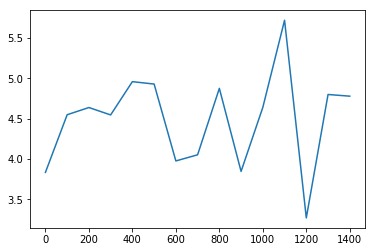

In [39]:
plt.plot(Wind_table['Y'], np.sqrt(Wind_table['Wx']**2+Wind_table['Wz']**2))

Model R^2 is: 0.9999701940775029


[01:11:58] [DEBUG]: update_title_pos
[01:11:58] [DEBUG]: update_title_pos
[01:11:58] [DEBUG]: update_title_pos
[01:11:58] [DEBUG]: update_title_pos
[01:11:58] [DEBUG]: update_title_pos


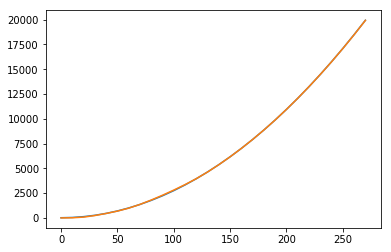

In [40]:

# TRAIN LINEAR REGRESSION TO FIND AERODYNAMIC COEFFICIENT
F_table["V^2"] = F_table['V']**2 
train, test = train_test_split(F_table, test_size=0.1)
lr = LinearRegression(normalize=False)
lr.fit(train["V^2"].values.reshape(-1, 1), train["Fa"])
score = lr.score(test["V^2"].values.reshape(-1, 1), test["Fa"])
print(f"Model R^2 is: {score}")
plt.plot(F_table["V"], Fa_p, F_table["V"], F_table["Fa"])

In [41]:
Fa_p = lr.predict(X=F_table["V^2"].values.reshape(-1, 1))


In [90]:
V0 = 250
alpha = 0
alpha = np.deg2rad(alpha)
V = np.array([V0*np.cos(alpha), 0, V0*np.sin(alpha)])
Pos = np.array([150, 1500, 150])
m = 1
delta_t = 0.01
g = 9.81
C = lr.coef_[0]


@dataclass
class WindPredictor:
    winds: pd.DataFrame
    _step: int = None
    
    def __post_init__(self):
        if not self.winds.shape[0]:
            raise ValueError("Wind predictor takes a DataFrame for wind speeds which has at least one point")
        _logger.info("Trying to detect which type of wind model is needed (calculate deltas in a dataset)...")
        if self.winds.shape[0] == 1:
            _logger.info("Wind dataset has only one row, we don't need any dynamic step calculation")
            self.predict_dynamic = False
            self._step = 1
        else:
            wind_step_deltas: np.ndarray = np.array(self.winds['Y'])[:-1] - np.array(self.winds['Y'])[1:]
            _logger.info(wind_step_deltas)
            self.predict_dynamic = not np.all(wind_step_deltas == wind_step_deltas[0])
            _logger.info(f"Wind dataset will be predicted using dynamic step variation: {self.predict_dynamic}")
            if not self.predict_dynamic:
                self._step = wind_step_deltas[0].ravel()
    
    def predict(self, h: float):
        if self.predict_dynamic:
            return self._predict_dynamic_step(h)
        else:
            return self._predict_static_step(h)
    
    def _predict_static_step(self, h: float):
        wind = self.winds.iloc[min(int(h // self._step), self.winds.shape[0] - 1)]
        return np.array([wind['Wx'], 0, wind['Wz']])
    
    def _predict_dynamic_step(self, h: float):
        deltas = self.winds['Y'] - h
        wind = self.winds.iloc[deltas[deltas < 0].idxmax()]
        return np.array([wind['Wx'], 0, wind['Wz']])


@dataclass
class WindyModel:
    v0: float
    pos0: np.array
    alpha: float
    mass: float
    aerodynamic_coef: float
    winds: WindPredictor
    g: float = 9.81
    verbose: Union[bool, int] = False
    
    v: np.ndarray = None
    run_time: float = None
    pos: np.ndarray = None
    
    @dataclass
    class ModelState:
        v: np.array
        pos: np.array
        time: float
        
    def __post_init__(self):
        self._log = logging.getLogger(f'{__name__}.{self.__class__.__name__}[{id(self)}]')
        if isinstance(self.verbose, bool):
            self.verbose = logging.DEBUG if self.verbose else logging.CRITICAL
        self._log.setLevel(self.verbose)
        self.alpha = np.deg2rad(self.alpha)
        self.v0 = np.array([self.v0*np.cos(self.alpha), 0, self.v0*np.sin(self.alpha)])
        self.reset()
    
    def reset(self):
        self.v = self.v0
        self.pos = self.pos0
        self.run_time = 0
    
    # function that returns dy/dt
    def wind_model(self, v: np.ndarray, time: np.ndarray):
        v_mod = np.linalg.norm(v)
        dydt = np.array([
            -self.aerodynamic_coef / self.mass * v[0] * v_mod,
            -self.aerodynamic_coef / self.mass * v[1] * v_mod - self.g,
            -self.aerodynamic_coef / self.mass * v[2] * v_mod,
        ])
        return dydt.ravel()
    
    def solve_velocities(self, time: np.ndarray):
        return odeint(self.wind_model, self.v0, time)
    
    @property
    def current_wind(self) -> np.array:
        return self.winds.predict(self.pos[1])
    
    @property
    def aerodynamic_acc(self) -> np.array:
        return -self.v*np.linalg.norm(self.v)*self.aerodynamic_coef / self.mass
    
    def step(self, dt: float):
        self._log.debug(f"Current position: {self.pos[1]:.2f}m above ground.")
        self._log.debug(f"Aerodynamic acc: {self.aerodynamic_acc}")
        self._log.debug(f"Winds: {self.current_wind}")
        self.v = np.asarray(self.v) + self.aerodynamic_acc*dt + dt*np.array([0, -self.g, 0])
        self._log.debug(f"Object's speed is: {self.v}")
        v_eff = self.current_wind + self.v
        self._log.debug(f"Effective speed is: {v_eff}")
        self.pos = self.pos + np.asarray(v_eff) * dt
        self._log.debug(f"Position is: {self.pos}")
        self.run_time += dt
    
    def predict(self, point: np.ndarray, reset: bool=True, **run_kwargs) -> np.array:
        if reset:
            self.reset()
        self.run(**run_kwargs)
        starting_point = point - self.state.pos + 2*np.array(self.pos0)
        starting_point[1] = self.pos0[1]
        return starting_point
    
    def score(self, starting_point: np.array, destination_point: np.array, reset: bool=True, **run_kwargs) -> Tuple[np.ndarray, float]:
        saved_pos0 = self.pos0
        try:
            self.pos0 = starting_point
            if reset:
                self.reset()
            self.run(**run_kwargs)
            landing_point = self.state.pos
            landing_point[1] = destination_point[1]
            return landing_point, np.linalg.norm(landing_point - destination_point)
        except Exception as e:
            self.pos0 = saved_pos0
            raise e
        finally:
            self.pos0 = saved_pos0
        
    @property
    def state(self) -> 'ModelState':
        return self.ModelState(v=self.v, pos=self.pos, time=self.run_time)
        
    def run(self, max_steps: int=None, dt: float=0.01) -> Sequence['ModelState']:
        step = 0
        states = []
        while self.pos[1] > 0 and (max_steps is None or step < max_steps):
            self.step(dt)
            step += 1
            states.append(self.state)
            self._log.debug(f"State is: {self.state}")
        self._log.info(f"Final state is: {self.state}")
        if max_steps is not None and step >= max_steps:
            self._log.warning(f"WARN: stopped after maximum iterations: {step}")
        return states

In [91]:
winds = WindPredictor(Wind_table)
model = WindyModel(winds=winds, pos0=[0, 1000, 0], verbose=logging.INFO, v0=250, alpha=0, mass=100, aerodynamic_coef=lr.coef_)

[02:19:54] [INFO]: Trying to detect which type of wind model is needed (calculate deltas in a dataset)...
[02:19:54] [INFO]: [-100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
[02:19:54] [INFO]: Wind dataset will be predicted using dynamic step variation: False


In [92]:
%%time
states = model.run()
print(f"Finished in {len(states)}. Took: {model.state.time} seconds.")

[02:19:57] [INFO]: Final state is: WindyModel.ModelState(v=array([  3.39498068, -59.51737493,   0.        ]), pos=array([ 9.63431647e+02, -3.36993883e-01, -4.68488000e+01]), time=22.76000000000076)


Finished in 2276. Took: 22.76000000000076 seconds.
Wall time: 2.84 s


In [96]:
%%time
starting_point = model.predict((0,0,0), dt=0.005)
print(starting_point)

[02:21:48] [INFO]: Final state is: WindyModel.ModelState(v=array([  3.39963246, -59.51624523,   0.        ]), pos=array([ 9.65089832e+02, -2.27322822e-01, -4.68607500e+01]), time=22.764999999999755)


[-965.08983166 1000.           46.86075   ]
Wall time: 5.38 s


In [97]:
%%time
model.score(starting_point, (0,0,0), dt=0.001)

[02:22:16] [INFO]: Final state is: WindyModel.ModelState(v=array([  3.40445985, -59.51511257,   0.        ]), pos=array([ 1.31125011, -0.02081325, -0.00331   ]), time=22.767000000004842)


Wall time: 28.4 s


(array([ 1.31125011,  0.        , -0.00331   ]), 1.3112542828293914)

[02:20:28] [DEBUG]: update_title_pos
[02:20:28] [DEBUG]: update_title_pos
[02:20:28] [DEBUG]: update_title_pos
[02:20:28] [DEBUG]: update_title_pos


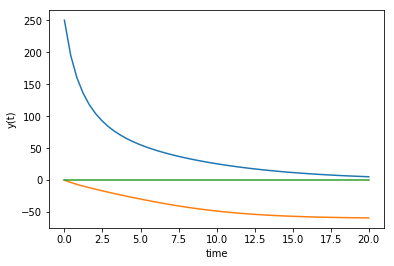

,0,1,2
45,6.951585,-58.533963,0.0
46,6.508869,-58.681340,0.0
47,6.093726,-58.813532,0.0
48,5.704533,-58.932017,0.0
49,5.339747,-59.038141,0.0


In [95]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# time points
t = np.linspace(0,20)
y = model.solve_velocities(t)

# plot results
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()
display(pd.DataFrame(y).tail())